# Sentiment Analysis with Hugging Face

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

In [56]:
!pip install simpletransformers

In [57]:
!pip install accelerate>=0.20.1 transformers

!pip install -U accelerate

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification

from datasets import load_metric
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

In [59]:
!pip3 install huggingface_hub

In [60]:
from huggingface_hub import notebook_login

notebook_login()

In [61]:
# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

In [62]:
# Load the train dataset
df_train = pd.read_csv('Train.csv')

df_train.head()


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [64]:
df_train['label'].unique()

array([ 0.        ,  1.        , -1.        ,         nan,  0.66666667])

In [65]:
df_train['agreement'].unique()

array([1.        , 0.66666667, 0.33333333,        nan])

In [66]:
#Loading the test dataset
df_test = pd.read_csv('Test.csv')

#Check for NaN values
df_test.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [67]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [68]:
# removing NaN values from test dataset
df_test = df_test.dropna()

df_test.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

In [69]:
# Find rows with missing values in the 'agreement' column of train dataset

df_train[df_train['agreement'].isnull()]

,tweet_id,safe_text,label,agreement
4798,RQMQ0L2A,#lawandorderSVU,NaN,NaN
4799,I cannot believe in this day and age some pare...,1,0.666667,NaN


In [70]:
# Shift the attributes of row 4799 one step to the right

df_train.iloc[4799] = df_train.iloc[4799].shift(1)

df_train.iloc[4799]

tweet_id                                                  None
safe_text    I cannot believe in this day and age some pare...
label                                                        1
agreement                                             0.666667
Name: 4799, dtype: object

In [71]:
# Convert 'label' column to float

df_train['label'] = df_train['label'].astype(float)

In [72]:
# Replace NaN value in row 4798 of 'label' column with '0', i.e. Neutral Sentiment
df_train.loc[4798, 'label'] = 0

# Replace NaN in row 4798 of 'agreement' column with '1'
df_train.loc[4798, 'agreement'] = 1

In [73]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10000 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10001 non-null  float64
 3   agreement  10001 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


# DATA PROCESSING

In [74]:
# Convert all characters in 'safe_text' column to lower case for both train & test datasets

df_train['safe_text']=df_train['safe_text'].str.lower()

df_test['safe_text']=df_test['safe_text'].str.lower()

In [75]:
# Function to remove whitespaces and special characters

def clean_text(text):
    # Replace special characters with an empty string
    text = ''.join(e for e in text if (e.isalnum() or e.isspace()))
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

# Apply the function to the 'text_column'
df_train['safe_text'] = df_train['safe_text'].apply(clean_text)

# Display the DataFrame
df_train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,me amp the big homie meanboy3000 meanboy mb mb...,0.0,1.0
1,E3303EME,im 100 thinking of devoting my career to provi...,1.0,1.0
2,M4IVFSMS,whatcausesautism vaccines do not vaccinate you...,-1.0,1.0
3,1DR6ROZ4,i mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,thanks to user catch me performing at la nuit ...,0.0,1.0


<Axes: xlabel='label', ylabel='count'>

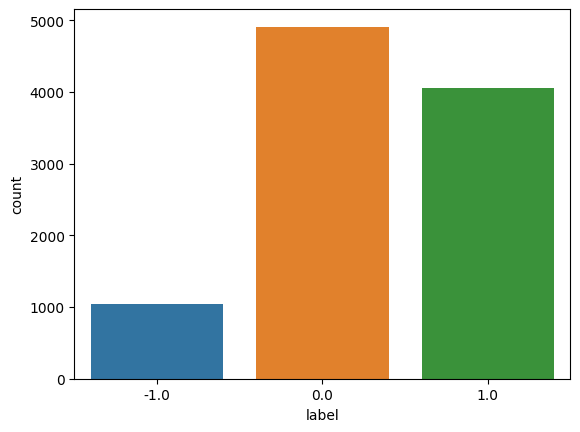

In [76]:
# visualizing the label column in the train dataset

sns.countplot(x=df_train['label'])

From the plot above, we can deduce the following.
Close to 50% of the tweets, around 5,000 tweets had Neutral Sentiments. The Positive Sentiment tweets was next with around 4,000 tweets, with the negative tweets being the least.

In [80]:
# Split the train data => {train, eval}
train, eval = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['label'])

In [81]:
train.head()

,tweet_id,safe_text,label,agreement
1641,CQDD6QLM,new user hey love mmr manymenrecords youaintgo...,0.0,1.000000
3907,5GV8NEZS,s1256 new extends exemption from charitable im...,0.0,1.000000
336,I4D043ST,user esp when mercury free vaccines are available,1.0,0.666667
6861,CKX52Y8G,my life your entertainment yotc mmr exotics url,0.0,1.000000
720,07S3NL2T,baby luna is sore from her vaccines poorpuppy,0.0,0.666667


Examples of Positive Tweets, i.e tweets with Label 1:

In [77]:
train[train['label'] == 1]['safe_text'].values[:5]

array(['user esp when mercury free vaccines are available',
       'reagans school sent flyer offering flu vaccines nice no insurance cost is 500 with insurance cost is 15 tn care its 0 say what',
       '104 cases of measles these idiots need to vaccinate their kids really',
       'aids n bcg vaccination could improve survival of hiv exposed babies url',
       'california governor signs strict school vaccine legislation gov jerry brown wasted no time tuesday in signing a url'],
      dtype=object)

Examples of Negative Tweets, i.e tweets with Label -1:

In [78]:
train[train['label'] == -1]['safe_text'].values[:5]

array(['user shld put out a statement user shameful user tells fb followers not to worry about measles url',
       'user vaccines causes brain swelling fever seizures and ultimately brain damage encephalitis autism read package inserts',
       'user hearthiswell vaccines r linked 2 autism ibd peds note mmr 15 mos cdcwhistleblower breakabillion b1less url',
       'you couldnt pay me enough to vaccinate my child no way in hell notachance',
       'user user she has a son with autism when born allergies to food she needs to learn how vaccines and glyphosate interact'],
      dtype=object)

Examples of Neutral Tweets, i.e tweets with Label 0:

In [79]:
train[train['label'] == 0]['safe_text'].values[:5]

array(['new user hey love mmr manymenrecords youaintgotnoeazyinyourserato trappfly comingsoon user url',
       's1256 new extends exemption from charitable immunity for certain civil actions to persons of any age who are be url',
       'my life your entertainment yotc mmr exotics url',
       'baby luna is sore from her vaccines poorpuppy',
       'how vaccines changed the course of us disease over time url'],
      dtype=object)

In [82]:
eval.head()

,tweet_id,safe_text,label,agreement
5818,Y8PQ0BT7,so nervous the babys getting vaccines at user ...,1.0,0.666667
7842,C9Z6JBSS,aids n a malaria vaccine in children with hiv ...,0.0,0.666667
880,0VE4NWWQ,measles outbreak hits texas church that preach...,1.0,0.666667
9072,RHQRUF14,thank you user for mtg with your staff we look...,1.0,1.000000
288,ZWEP2IL4,health district offers nocost immunizations fo...,1.0,0.666667


In [83]:
print(f"New DataFrame Shapes: train is {train.shape}, eval is {eval.shape}")

New DataFrame Shapes: train is (8000, 4), eval is (2001, 4)


In [84]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [85]:
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [86]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [87]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

In [88]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8000
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2001
    })
})

In [ ]:
# dataset['train']

In [89]:
# Configure the training parameters like `num_train_epochs`.

training_args = TrainingArguments("pakornor/roberta-base", num_train_epochs=3, load_best_model_at_end=True, push_to_hub=True,
                                  evaluation_strategy= "steps", save_strategy= 'steps')

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [90]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [93]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

In [94]:
# Launch the learning process: training
trainer.train()

Step,Training Loss,Validation Loss
500,0.785800,0.720192
1000,0.754300,0.712429
1500,0.745200,0.713984
2000,0.719400,0.672390
2500,0.672900,0.644087
3000,0.647900,0.642171


TrainOutput(global_step=3000, training_loss=0.7209306335449219, metrics={'train_runtime': 2520.4765, 'train_samples_per_second': 9.522, 'train_steps_per_second': 1.19, 'total_flos': 6314722025472000.0, 'train_loss': 0.7209306335449219, 'epoch': 3.0})

In [95]:
trainer.push_to_hub()

'https://huggingface.co/pakornor/roberta-base/tree/main/'

In [97]:
model.push_to_hub("pakornor/roberta-base")

tokenizer.push_to_hub("pakornor/roberta-base")

CommitInfo(commit_url='https://huggingface.co/pakornor/roberta-base/commit/c202a1a44a2a067c8b82184d26b807497a7020c3', commit_message='Upload tokenizer', commit_description='', oid='c202a1a44a2a067c8b82184d26b807497a7020c3', pr_url=None, pr_revision=None, pr_num=None)

In [98]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [99]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [100]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.6421710848808289,
 'eval_accuracy': 0.7511244377811095,
 'eval_runtime': 53.945,
 'eval_samples_per_second': 37.093,
 'eval_steps_per_second': 4.653}